#### Data Description

- **userid** - a unique number that identifies each player.
- **version** - whether the player was put in the control group (gate_30 - a gate at level 30) or the test group (gate_40 - a gate at level 40).
- **sum_gamerounds** - the number of game rounds played by the player during the first week after installation
- **retention_1** - did the player come back and play 1 day after installing?
- **retention_7** - did the player come back and play 7 days after installing?

As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention and game rounds.

In [58]:
# import pacakages

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

from scipy.stats import shapiro
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action = "ignore", category = FutureWarning)

pd.set_option("display.max_columns", None)
pd.options.display.float_format = '{:.4f}'.format

In [59]:
 # read the data

data = pd.read_csv("cookie_cats.csv")
print("The shape of the data is:",data.shape)
data.head()


The shape of the data is: (90189, 5)


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [60]:
# Checking the data types

data.dtypes

userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object

In [61]:
# Chceking the summary statistics - Looks like we have a huge outlier in sum_gamerounds

data.sum_gamerounds.describe()

count   90189.0000
mean       51.8725
std       195.0509
min         0.0000
25%         5.0000
50%        16.0000
75%        51.0000
max     49854.0000
Name: sum_gamerounds, dtype: float64

In [62]:
# Chceking the outlier - So we have a single user from gate_30 who played 49854 total rounds in the first week afetr installation

data[data.sum_gamerounds == 49854]

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True


In [63]:
# Chceking the no of unique users - we have all the users as unique and no duplicate users

data.userid.nunique()

90189

In [64]:
# counting the no. of playerrs in each A/B group - yes we have roughly the same no of players in our A/B group

data.groupby('version')[["userid"]].nunique()

,userid
version,
gate_30,44700
gate_40,45489


In [65]:
# Grouping the control and test groups to see the summary stats of sum_gamerounds

data.groupby("version").sum_gamerounds.agg(["count","median","mean","std","max"])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17.0000,52.4563,256.7164,49854
gate_40,45489,16.0000,51.2988,103.2944,2640


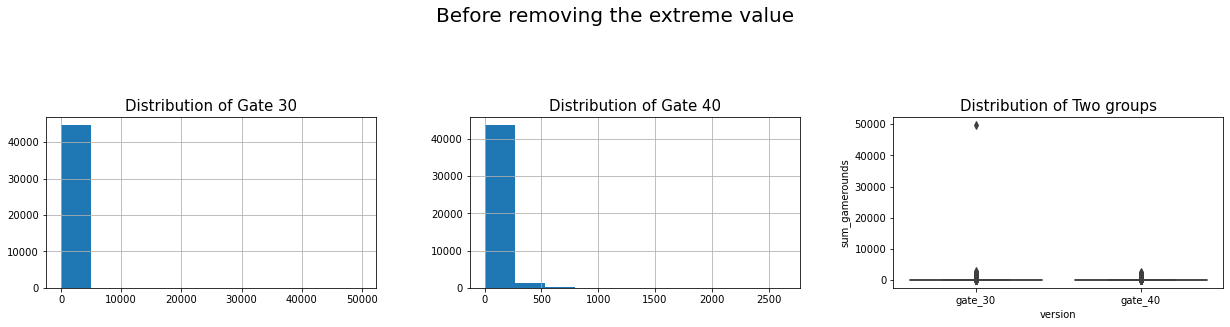

In [66]:
fig, axes = plt.subplots(1, 3, figsize = (18,5))

data[data.version == "gate_30"].hist(["sum_gamerounds"], ax = axes[0])
data[data.version == "gate_40"].hist(["sum_gamerounds"], ax = axes[1])

sns.boxplot(x = data.version, y = data.sum_gamerounds, ax = axes[2])

plt.suptitle("Before removing the extreme value", fontsize = 20)
axes[0].set_title("Distribution of Gate 30", fontsize = 15)
axes[1].set_title("Distribution of Gate 40", fontsize = 15)
axes[2].set_title("Distribution of Two groups", fontsize = 15)


plt.tight_layout(pad = 4)

Text(0.5, 0.98, 'Before removing the extreme value')

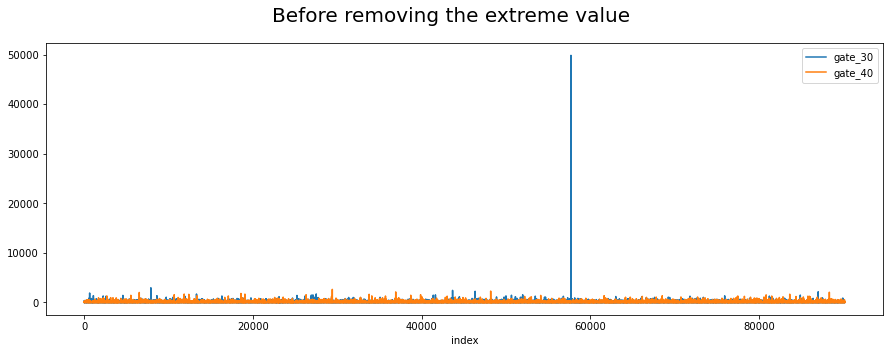

In [67]:
# you can see from the below graph the outlier in gate_30 who played a toal of 49k rounds

data[data.version == "gate_30"]["sum_gamerounds"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "gate_30", figsize=(15,5))
data[data.version == "gate_40"]["sum_gamerounds"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "gate_40", figsize=(15,5))

plt.suptitle("Before removing the extreme value", fontsize = 20)

In [68]:
# Removing the outlier

data = data[data.sum_gamerounds < data.sum_gamerounds.max()]

In [69]:
# seeing the summary stats again

data.describe()

,userid,sum_gamerounds
count,90188.0000,90188.0000
mean,4998396.7979,51.3203
std,2883297.8659,102.6827
min,116.0000,0.0000
25%,2512211.2500,5.0000
50%,4995804.0000,16.0000
75%,7496460.7500,51.0000
max,9999861.0000,2961.0000


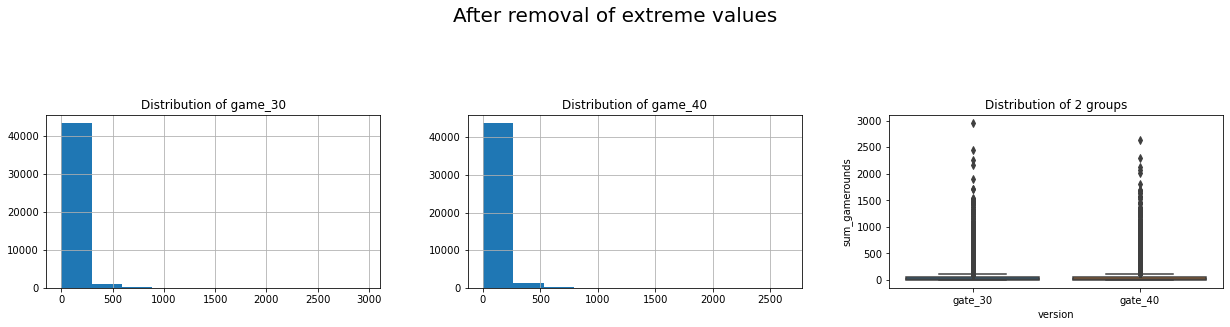

In [70]:
# Lets see the distributions again after removal of outlier

fig, axes = plt.subplots(1, 3, figsize=(18,5))
data[data.version == "gate_30"].hist(["sum_gamerounds"], ax = axes[0])
data[data.version == "gate_40"].hist(["sum_gamerounds"], ax = axes[1])

sns.boxplot(x = "version", y = "sum_gamerounds", data = data)

plt.suptitle("After removal of extreme values", fontsize = 20)
axes[0].set_title("Distribution of game_30")
axes[1].set_title("Distribution of game_40")
axes[2].set_title("Distribution of 2 groups")

plt.tight_layout(pad = 4)

Text(0.5, 0.98, 'After Removal of Extreme Values ')

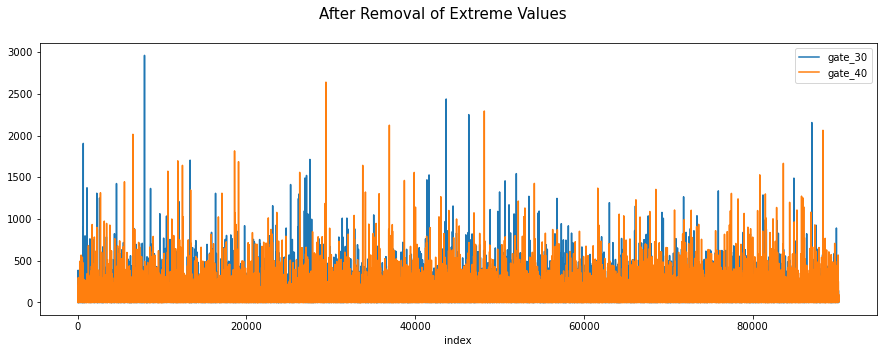

In [71]:
# As you can see from the graph after the removal of outlier, the distribution is a lot more clear than before

data[data.version == "gate_30"]["sum_gamerounds"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "gate_30", figsize=(15,5))
data[data.version == "gate_40"]["sum_gamerounds"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "gate_40", figsize=(15,5))

plt.suptitle("After Removal of Extreme Values ", fontsize=15)

Text(0, 0.5, 'no. of players')

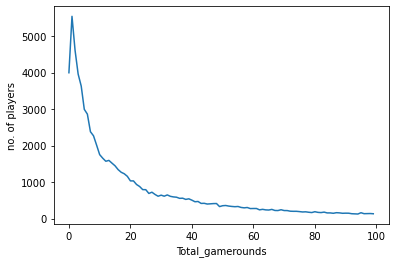

In [72]:
# ploting the distribution of gamerounds

gamerounds = data.groupby('sum_gamerounds')["userid"].count().reset_index()
gamerounds["userid"].head(100).plot()
plt.xlabel("Total_gamerounds")
plt.ylabel("no. of players")

- A lot of players have their gamerounds as 0 ie they just installed the game and never played it

In [73]:
data[data["sum_gamerounds"] == 0]["userid"].count()

3994

- 3994 people installed the game but never played it.

- A common metric of the video game industry to know how fun or how engaging a specific game is is its retention. That is if the player come back 1 day and 7 day after the game is being installed. The higher the retension is, the easier iit is to make a larger player base

In [74]:
# Lets look at the the 1 Day and & 7 Day retention rates

print("The 1 day retention is:", round(data[data["retention_1"] == True]["userid"].nunique()/data.shape[0]*100, 2))
print("The 7 day retention is:", round(data[data["retention_7"] == True]["userid"].nunique()/data.shape[0]*100, 2))

The 1 day retention is: 44.52
The 7 day retention is: 18.61


- A little less than half of the people who installed game came back after 1 day of installation
- 18% players came back 7 days after installing the game

In [90]:
# Since we have benchmarks now - Lets see the retention rates of both of our groups control as well as test groups

# Control group is "gate_30"

retention1_gate30 = round(data[(data["version"] == "gate_30") & (data["retention_1"] == True)]["userid"].nunique()/data[data["version"] == "gate_30"]["userid"].count()*100,2)
retention7_gate30 = round(data[(data["version"] == "gate_30") & (data["retention_7"] == True)]["userid"].nunique()/data[data["version"] == "gate_30"]["userid"].count()*100,2)

retention1_gate40 = round(data[(data["version"] == "gate_40") & (data["retention_1"] == True)]["userid"].nunique()/data[data["version"] == "gate_40"]["userid"].count()*100,2)
retention7_gate40 = round(data[(data["version"] == "gate_30") & (data["retention_7"] == True)]["userid"].nunique()/data[data["version"] == "gate_40"]["userid"].count()*100,2)

In [91]:
print("Retension after 1 day for control", retention1_gate30)
print("Retension after 7 day for control", retention7_gate30)
print("Retension after 1 day for test", retention1_gate40)
print("Retension after 7 day for control", retention7_gate40)

Retension after 1 day for control 44.82
Retension after 7 day for control 19.02
Retension after 1 day for test 44.23
Retension after 7 day for control 18.69


**Observations**
- There was a slight decrease in 1 day retention when the gate was moved from level 30 to level 40. Earlier it was 44.8, now its 44.2
- There is also a decrease in the 7 day retention when the gate was moved from level 30 to level 40. Earlier it was 19.0 which dropped to 18.6

But while we are certain of the difference in the data, how certain should we be that a gate at level 40 will be worse in the future?There are a couple of ways we can get at the certainty of these retention numbers. Here we will use **bootstrapping**.

#### A/B testing-Bootstrapping

Testing Steps:

- Creating 500 samples of dataset (bootstraping)
- Calculating 1-day & 7-days retentions for A/B groups
- Plotting the bootstrap distributions
- Calculating retention rate difference between the two A/B groups
- Calculating the probability that 1-day & 7-days retentions are greater when the gate is at level 30
- Evaluating results and making recommendation

In [94]:
data.groupby('version')["retention_7"].mean()

version
gate_30   0.1902
gate_40   0.1820
Name: retention_7, dtype: float64

In [98]:
# Creating 500 samples of dataset and calculating their 1 day and 7 days retentions for A/B group

boot_retention1 = []
boot_retention7 = []

# creating samples of 500 

for i in range(500):

    data_retention1 = data.sample(frac = 1, replace = True).groupby("version")["retention_1"].mean()
    data_retention7 = data.sample(frac = 1, replace = True).groupby("version")["retention_7"].mean()

    boot_retention1.append(data_retention1)
    boot_retention7.append(data_retention7)


In [100]:
# making dataframes of both the bootstrapped samples

df_retention1 = pd.DataFrame(boot_retention1)
df_retention7 = pd.DataFrame(boot_retention7)

Text(0.5, 1.0, 'Retention Rate Distribution After 7 day')

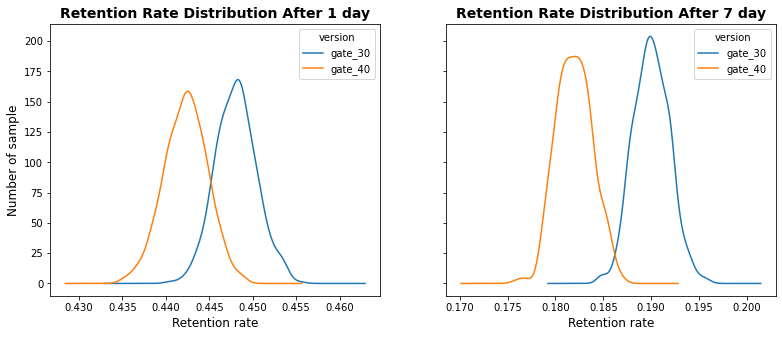

In [109]:
# Lets plot the distribution of both the dataframes

fig, axes  = plt.subplots(1, 2, sharey= True, figsize=(13,5))

df_retention1.plot.kde(ax = axes[0])
axes[0].set_xlabel("Retention rate", size = 12)
axes[0].set_ylabel("Number of sample", size = 12)
axes[0].set_title("Retention Rate Distribution After 1 day", fontweight = "bold", size = 14)

df_retention7.plot.kde(ax = axes[1])
axes[1].set_xlabel("Retention rate", size = 12)
axes[1].set_ylabel("Number of sample", size = 12)
axes[1].set_title("Retention Rate Distribution After 7 day", fontweight = "bold", size = 14)

- If Gate was at level 30 then players retention after 1 day is near about 44 to 45.5% and retintion after 7 days is 18.5 to 19.5%
- However, If we move the gate from level 30 to level 40, then retention in players after 1 day is 43.5 to 44.5 % and that after 7 days is 17.5 to 18.5 %
- This shows that retention is higher in case of gate at level 30 then at level 40. But what is the probability that the gate at level 30 would yield higher retention, lets check that

In [112]:
# Calculating the percentage differnce between the two A/B groups

df_retention1["diff"] = (df_retention1["gate_30"] - df_retention1["gate_40"])/df_retention1["gate_40"] *100
df_retention7["diff"] = (df_retention7["gate_30"] - df_retention7["gate_40"])/df_retention7["gate_40"] *100

In [114]:
df_retention7

version,gate_30,gate_40,diff
retention_7,0.1906,0.1827,4.3170
retention_7,0.1899,0.1840,3.2094
retention_7,0.1890,0.1795,5.2957
retention_7,0.1905,0.1819,4.7344
retention_7,0.1920,0.1805,6.3946
...,...,...,...
retention_7,0.1905,0.1792,6.2769
retention_7,0.1881,0.1816,3.5942
retention_7,0.1898,0.1812,4.7368
retention_7,0.1892,0.1813,4.3505


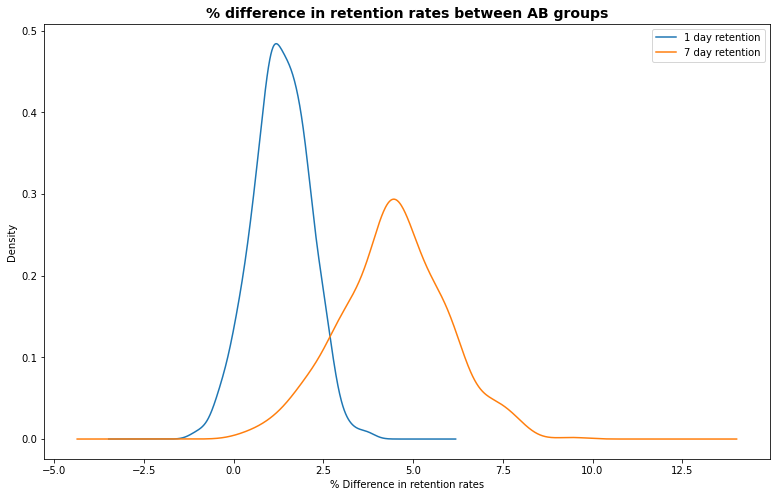

In [127]:
# Lets plot the bootstrap differences 

fig, axes = plt.subplots(1, sharey= True, figsize=(13,8))

df_retention1["diff"].plot.kde(ax = axes, label = "1 day retention")
df_retention7["diff"].plot.kde(ax = axes, label = "7 day retention")
axes.set_xlabel("% Difference in retention rates")
axes.set_title("% difference in retention rates between AB groups", fontweight= "bold", size = 14)
plt.legend()
plt.show()

In [138]:
# Calculating the probability that 1-day and 7-day retention is higher when the gate is at level 30 

prob_retention1 = (df_retention1["diff"] > 0).sum() / len(df_retention1["diff"])
prob_retention7 = (df_retention7["diff"] > 0).sum() / len(df_retention7["diff"])

In [143]:
# Printing the probabilities

print("The probability that 1 day retention is greater when the gate is at level 30 :", round(prob_retention1,2)*100,"%")
print("The probability that 7 day retention is greater when the gate is at level 30 :", round(prob_retention7,2)*100,"%")

The probability that 1 day retention is greater when the gate is at level 30 : 95.0 %
The probability that 7 day retention is greater when the gate is at level 30 : 100.0 %


#### **Conclusion**

The results show that there is a 100% probability that 7-day retention is higher when the gate is at level 30 than when it is at level 40.
If we want to keep the retention high both 1-day and 7-day retention- we should not move the gate from level 30 to level 40.